In [38]:
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
import pandas as pd

print("imported")

imported


In [ ]:
# ——— 1) Load & prepare data ———
data    = np.load("data/threebody_dataset2.npz")

# Drop the last sample on each array
masses  = data["masses"][:-1]                          # (N-1,3)
pos     = data["init_pos"][:-1].reshape(-1, 6)         # (N-1,6)
vel     = data["init_vel"][:-1].reshape(-1, 6)         # (N-1,6)
y       = data["y"][:-1].reshape(-1, 1)                # (N-1,1)

# Now stack into your feature matrix
X       = np.hstack([masses, pos, vel])                # (N-1,15)




In [40]:
# Shuffle, scale, one-hot
rng   = np.random.RandomState(42)
perm  = rng.permutation(len(X))
X, y  = X[perm], y[perm]

In [41]:
scaler    = StandardScaler().fit(X)
X         = scaler.transform(X)

ohe       = OneHotEncoder(sparse_output=False).fit(y)
Y_onehot  = ohe.transform(y)
y_labels  = y.squeeze()

In [42]:
# ——— 2) Split into train/val/test (70/15/15) ———
# 15% hold-out test set
X_trainval, X_test, Y_trainval, Y_test, y_trainval, y_test = train_test_split(
    X, Y_onehot, y_labels,
    test_size=0.15,
    random_state=42,
    stratify=y_labels
)
# From remaining 85%, take 15% of original → val_size = 0.15/0.85
val_size = 0.15 / 0.85
X_train, X_val, Y_train, Y_val = train_test_split(
    X_trainval, Y_trainval,
    test_size=val_size,
    random_state=42,
    stratify=y_trainval
)
print(f"Train/Val/Test sizes: {len(X_train)}/{len(X_val)}/{len(X_test)}")

Train/Val/Test sizes: 210/45/45


In [43]:
# Prepare sequences (each sample as length-1 sequence)
X_train_seqs = [x[np.newaxis, :] for x in X_train]
Y_train_seqs = [y[np.newaxis, :] for y in Y_train]
X_val_seqs   = [x[np.newaxis, :] for x in X_val]
Y_val_seqs   = [y[np.newaxis, :] for y in Y_val]
X_test_seqs  = [x[np.newaxis, :] for x in X_test]
Y_test_seqs  = [y[np.newaxis, :] for y in Y_test]

In [44]:
# ——— 3) Hyperparameter grid ———
param_grid = {
  "units":              [500, 1000, 2000],
  "sr":                 [1.5,  2.0],       # spectral radius
  "lr":                 [0.5, 0.7],       # leaking rate
  "input_scaling":      [2.0, 2.5, 3.0],
  "rc_connectivity":    [0.2, 0.3],
  "input_connectivity": [0.5, 0.7, 1.0 ],
  "ridge":              [1e-8, 1e-6, 1e-10]
}

best_score  = -np.inf
best_params = None
best_model  = None

rpy.verbosity(0)
rpy.set_seed(42)

In [45]:
# ——— 4) Grid search on validation set ———
for params in ParameterGrid(param_grid):
    reservoir = Reservoir(
        units=params["units"],
        sr=params["sr"],
        lr=params["lr"],
        input_scaling=params["input_scaling"],
        rc_connectivity=params["rc_connectivity"],
        input_connectivity=params["input_connectivity"],
        seed=42
    )
    readout = Ridge(ridge=params["ridge"])
    model   = reservoir >> readout

    # train on train set
    model = model.fit(X_train_seqs, Y_train_seqs, warmup=0)

    # eval on validation set
    Y_val_pred = np.vstack(model.run(X_val_seqs)).squeeze()
    y_val_true = np.argmax(Y_val, axis=1)
    y_val_hat  = np.argmax(Y_val_pred, axis=1)
    val_acc    = accuracy_score(y_val_true, y_val_hat)

    if val_acc > best_score:
        best_score  = val_acc
        best_params = params
        best_model  = model

print("Completed grid search.")
print(f"Best params: {best_params}")
print(f"Best validation accuracy: {best_score:.4f}")

/Users/gudmundurandriguttormsson/Desktop/GU/advanced ML/Project/venv/lib/python3.13/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.02082e-16): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/Users/gudmundurandriguttormsson/Desktop/GU/advanced ML/Project/venv/lib/python3.13/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.00621e-16): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/Users/gudmundurandriguttormsson/Desktop/GU/advanced ML/Project/venv/lib/python3.13/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=9.04312e-17): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")
/Users/gudmundurandriguttormsson/Desktop/GU/advanced ML/Project/venv/lib/python3.13/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning

Completed grid search.
Best params: {'input_connectivity': 0.5, 'input_scaling': 2.0, 'lr': 0.5, 'rc_connectivity': 0.2, 'ridge': 1e-08, 'sr': 2.0, 'units': 2000}
Best validation accuracy: 0.9333


/Users/gudmundurandriguttormsson/Desktop/GU/advanced ML/Project/venv/lib/python3.13/site-packages/reservoirpy/nodes/readouts/ridge.py:17: LinAlgWarning: Ill-conditioned matrix (rcond=1.00945e-16): result may not be accurate.
  return linalg.solve(XXT + ridge, YXT.T, assume_a="sym")


In [46]:
# ——— 5) Final ESN test metrics ———
Y_test_pred = np.vstack(best_model.run(X_test_seqs)).squeeze()

y_pred = np.argmax(Y_test_pred, axis=1)
y_true = np.argmax(Y_test,      axis=1)

test_acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_acc * 100:.2f}%\n")

print(classification_report(
    y_true,
    y_pred,
    target_names=[str(c) for c in ohe.categories_[0]]
))

Test Accuracy: 88.89%

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.93      0.93      0.93        15
           2       0.88      0.93      0.90        15

    accuracy                           0.89        45
   macro avg       0.89      0.89      0.89        45
weighted avg       0.89      0.89      0.89        45



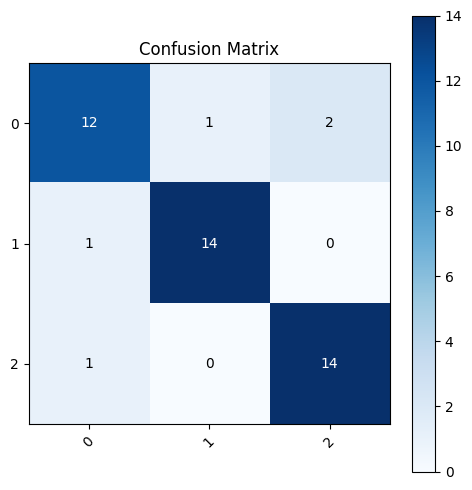

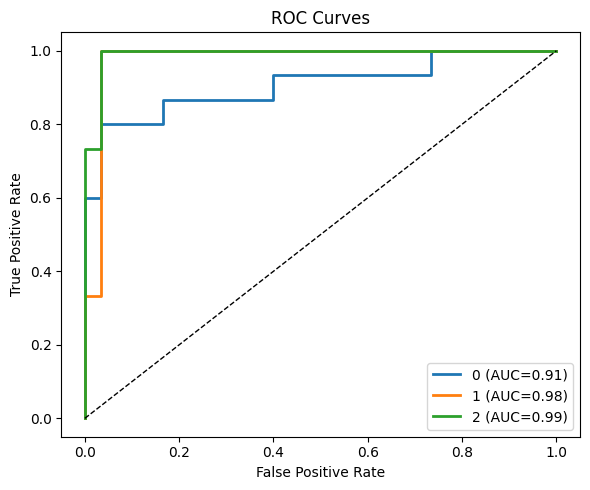

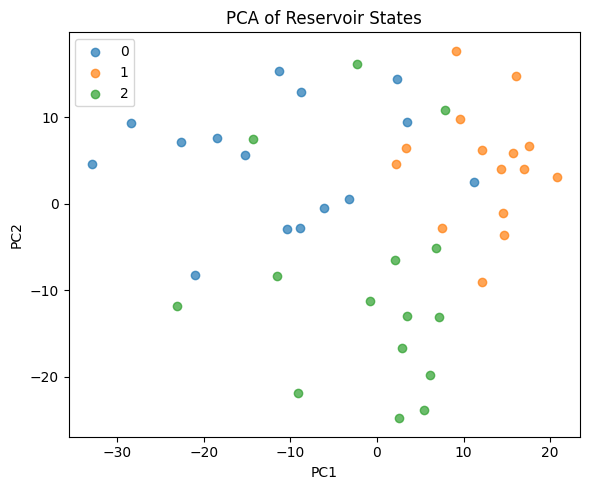

In [47]:
# ——— 6) Analysis plots ———
# a) Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
plt.title("Confusion Matrix")
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
plt.xticks(np.arange(len(ohe.categories_[0])), [str(c) for c in ohe.categories_[0]], rotation=45)
plt.yticks(np.arange(len(ohe.categories_[0])), [str(c) for c in ohe.categories_[0]])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center',
                 color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.tight_layout()
plt.show()

# b) ROC curves
n_classes = Y_test_pred.shape[1]
y_test_bin = label_binarize(y_true, classes=list(range(n_classes)))
plt.figure(figsize=(6,5))
for i, lab in enumerate([str(c) for c in ohe.categories_[0]]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], Y_test_pred[:, i])
    roc_auc     = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{lab} (AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# c) PCA scatter of reservoir states
reservoir_node = best_model.nodes[0]
states = [reservoir_node.run(seq).ravel() for seq in X_test_seqs]
states = np.vstack(states)

pca = PCA(n_components=2, random_state=42)
pcs = pca.fit_transform(states)

plt.figure(figsize=(6,5))
for idx, lab in enumerate([str(c) for c in ohe.categories_[0]]):
    mask = (y_true == idx)
    plt.scatter(pcs[mask,0], pcs[mask,1], alpha=0.7, label=lab)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of Reservoir States")
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
# define your new class names in the order of your one‐hot encoding
class_names = ['C', 'D', 'S']

roc_data = []
for i, lab in enumerate(class_names):
    # compute ROC for the i-th binary column
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], Y_test_pred[:, i])
    roc_auc    = auc(fpr, tpr)
    for f, t in zip(fpr, tpr):
        roc_data.append({
            "model": "ESN",
            "class": lab,
            "fpr":   f,
            "tpr":   t,
            "auc":   roc_auc
        })

df_roc = pd.DataFrame(roc_data)
df_roc.to_csv("roc_data_esn.csv", index=False)
